In [1]:
import sys,os
sys.path.append('../../')
from paths import *
from dadapy import data
import numpy as np
from time import time 
import matplotlib.pyplot as plt
# from dadapy._utils.stochastic_minimization_hamming import *
from dadapy.hamming import * 

rcpsize = 20
plt.rcParams['xtick.labelsize']= rcpsize
plt.rcParams['ytick.labelsize']=rcpsize
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams['font.size'] = rcpsize
plt.rcParams.update({'figure.autolayout': True})
#colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['ggplot']['axes.prop_cycle'].by_key()['color']
colors = plt.style.library['seaborn-v0_8']['axes.prop_cycle'].by_key()['color']
# colors = plt.style.library['seaborn-v0_8-dark-palette']['axes.prop_cycle'].by_key()['color']
from cycler import cycler
plt.rcParams['axes.prop_cycle'] = cycler(color=colors)
# print(plt.rcParams.keys())
#np.set_printoptions(precision=None)
markers = ['p','o','h','^','s','*']
plot_id = 0


start = time()

eps = 1E-7
L_list = np.arange(30,100+1,10,dtype=int)
M_flag = 1
N_list = L_list**2
geometry = 'Ising-square'
datafolder = f'/scratch/sacevedo/{geometry}/canonical/'

GRIDE = True
I3D = True
FCI = True
CD = True
MLE = True

/home/s/venv/lib/python3.12/site-packages/jax/_src/numpy/lax_numpy.py:166: UserWarning: Explicitly requested dtype float64 requested in asarray is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return asarray(x, dtype=self.dtype)


In [2]:
# ### COMPUTING
# T_list = [1.9]
# for L_id,L in enumerate(L_list):
#   print(f'{L=}')
#   for T_id,T in enumerate(T_list):
#     if T != np.inf:
#       datafile = datafolder + f'L{L}/T{T:.2f}.txt'
#       X = np.loadtxt(f'{datafile}').astype(int)
#     else:
#       pass
#     resultsfolder = makefolder(base=f'results/gride/',
#                               create_folder=True,
#                               L=L,
#                               T=T,
#                               )
#     if M_flag:
#       M0 = np.sum(X,axis=1)
#       indices = np.where(M0<0)
#       X[indices] = - X[indices]
# X = X[:1000]
# _data = data.Data(coordinates=X, maxk=X.shape[0]-1)
#     if GRIDE:
#       _data = data.Data(coordinates=X, maxk=X.shape[0]-1)
#       range_max = X.shape[0] - 1
#       ids_gride, ids_err_gride, rs_gride = _data.return_id_scaling_gride(range_max=range_max)
#       np.savetxt(resultsfolder+'gride.txt',np.transpose([ids_gride,
#                                                       ids_err_gride,
#                                                       rs_gride]))

In [5]:
ID_GRIDE = np.zeros(shape=(len(L_list)))
ID_BID = np.zeros(shape=ID_GRIDE.shape)
ID_FCI = np.zeros(shape=ID_GRIDE.shape)
ID_CD = np.zeros(shape=ID_GRIDE.shape)

Ns = 5000
Nsteps = int(1E6)
delta = 5E-4
alphamin = 0
alphamax = .1
histfolder = f'../distances/results/hist/'

T = 1.9
normalize = 1
for L_id,L in enumerate(L_list):
  ### GRIDE
  if GRIDE:
    k = 3
    resultsfolder = makefolder(base=f'results/gride/',
                            L=L,
                            T=float(T),
                            )
    ids_gride,ids_err_gride,rs_gride = np.loadtxt(resultsfolder+'gride.txt',unpack=True)
    ID_GRIDE[L_id] = ids_gride[k]
  ### BID
  optfolder0 = f'../BID/results/opt/L{L}/T{T:.2f}/'
  B = BID(
          alphamin=alphamin,
          alphamax=alphamax,
          seed=1,
          delta=delta,
          Nsteps=Nsteps,
          optfolder0=optfolder0,
          )
  (_,ID_BID[L_id],_,_,) = B.load_results()
  ### FCI
  if FCI:
    resultsfolder = makefolder(base=f'../FCI/results/FCI/',
                            create_folder=True,
                            precision=2,
                            global_flag=1,
                            L=L,
                            T=float(T),
                            M_flag=M_flag,
                            )
    ID_FCI[L_id], x0, err = np.loadtxt(resultsfolder + 'FCI_fit.txt',unpack=True)

if CD:
  ID_CD = np.loadtxt(f'../CD/results/ds_T{T:.2f}.txt')

### I3D
if I3D:
  resultsfolder = makefolder(base=f'../I3D/results/',
                          T=float(T),
                          )    
  Ls_I3D,ID_I3D = np.loadtxt(resultsfolder+'ds.txt',unpack=True)

if MLE:
  resultsfolder = f'../MLE/results/T_{T:.2f}/M_flag_1/'
  L_MLE,ID_MLE = np.loadtxt(resultsfolder + f'd.txt',unpack = True)

if normalize:
  ID_BID /= N_list
  if GRIDE:
    ID_GRIDE /= N_list
  if I3D:
    ID_I3D /= N_list
  if FCI:
    ID_FCI /= N_list 
  if CD:
    ID_CD /= N_list
  if MLE:
    ID_MLE /= L_MLE**2

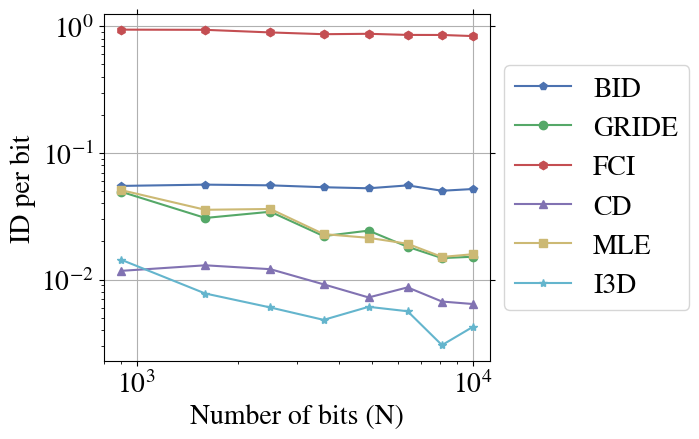

In [ ]:
fig,ax = plt.subplots(1)
ax.tick_params(axis='x', bottom=True, top=True)  # X-axis: ticks on bottom and top
ax.tick_params(axis='y', left=True, right=True)  # Y-axis: ticks on left and right

ax.plot(N_list,ID_BID,marker=markers[0],label='BID')
if GRIDE:
  ax.plot(N_list,ID_GRIDE,marker=markers[1],label='GRIDE')
if FCI:
  ax.plot(N_list,ID_FCI,marker=markers[2],label='FCI')
if CD:
  ax.plot(N_list,ID_CD,marker=markers[3],label='CD')
if MLE:
  ax.plot(L_MLE**2,ID_MLE,marker=markers[4],label='MLE')
if I3D:
  ax.plot(Ls_I3D**2,ID_I3D,marker=markers[5],label='I3D')


if normalize:
  ax.set_ylabel(f'ID per bit')
else:
  ax.set_ylabel(f'ID')
ax.set_xlabel(f'Number of bits (N)')
# ax.set_title(f'{T=:.2f}')

ax.legend()
# ax.plot(N_list,
#         N_list*a + b,
#         ls='dashed',
#         color='gray')

ax.set_yscale('log')
ax.set_xscale('log')
ax.grid()

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [15]:
fig.savefig(f'scaling_comparison.pdf',bbox_inches='tight')